Structure:

- Get images
  - Per patient
  - Train
  - Test
-Run all images through feature detection
-Take each patient, run PCA with k =?
-Run MLP classifier / linear discriminator

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import datetime

from sklearn.decomposition import PCA, KernelPCA

# %matplotlib notebook
%matplotlib inline

In [2]:
def fake_data(dir = './data', ptns=12, pchs=10):
  imgs = torch.rand((ptns, pchs,3, 224,224))
  os.mkdir(dir)
  classes = []
  for p in range(ptns):
    case = 'A' if torch.randn(1) > 0 else 'B'
    classes.append(case)
    p_name = "ptn-{}-{}".format(str(p).zfill(3), case)
    pth = os.path.join(dir, p_name)
    os.mkdir(pth)
    for i in range(pchs):
      im = imgs[int(p),i]
      if case is 'B':
        im = im / 2
      fname = os.path.join(dir ,p_name, str(i).zfill(3) + '.png')
      torchvision.utils.save_image(im, fname)
  return classes

In [3]:
!rm -fr data*
!rm -fr aug_data*
!ls

sample_data


In [4]:
dir = './data'
classes = fake_data(dir)
!ls

data  sample_data


In [5]:
def get_device():
  dev = "cuda:0" if torch.cuda.is_available() else "cpu"
  device = torch.device(dev)
  return device


def get_transform(dir):
  default_transform = transforms.Compose([transforms.CenterCrop(224), transforms.ToPILImage(), transforms.ToTensor()])
  dataset = torchvision.datasets.DatasetFolder(root=dir, loader=torchvision.io.read_image, extensions='.png', transform=default_transform)
  clc = []
  for img, lbl in dataset:
    clc.append(img)
  print("clc: [{} , {}]".format(len(clc),clc[0].shape))

  tn = torch.Tensor(len(clc), *clc[0].shape)
  print(tn.shape)
  for i in range(len(clc)):
    tn[i] = clc[i]
  print(tn.shape)
  tn.to(get_device())
  dim = [i for i in range(2, len(tn.shape))]
  print('dim is : {}'.format(dim))
  mean = tn.mean(dim=(0,*dim)).cpu()
  std = tn.std(dim=(0,2,3)).cpu()
  print("mean = {}".format(mean))
  print("std = {}".format(std))

  normal_transform = transforms.Compose([default_transform,
                                         transforms.Normalize(mean=mean, std=std)])
  return normal_transform

In [6]:
def batch_PCA_(imgs ,k=16):
  print("batch input size: {}".format(imgs.shape))
  ret = imgs.mean(dim=0)
  print("batch new size: {}".format(ret.shape))
  return ret

In [7]:
def get_class(ds, dir):
  cls = ds.find_classes(dir)[0]
  ret = []
  for c in cls:
    case = c[-1]
    ret.append(case)
  return ret

In [8]:
def batch_PCA(imgs, fx, k=8):
  bts = imgs.shape[0]
  print("Batch PCA input size: {}".format(imgs.shape))
  ftrs = fx(imgs).reshape(bts, -1).cpu().numpy()
  #ftr_var = (ftrs.T @ ftrs).cpu().numpy()
  PCA_comp = PCA(k, svd_solver='full').fit(ftrs)
  eig_vec = torch.Tensor(PCA_comp.components_)
  print("Eigen Vector size :{} , with max: {}".format(eig_vec.shape, eig_vec.max()))
  return eig_vec

In [9]:
def ds_img(imgs):
  s = imgs.shape[-1] // 8
  t = transforms.RandomCrop(s)
  return t(imgs)


In [10]:
class AutoEncoder(nn.Module):

  def __init__(self, head, rest):
    super(AutoEncoder, self).__init__()
    self.encode = head
    self.decode = reset
  
  def forward(self, imgs):
    x = self.encode(imgs)
    return self.decode(x)

  def feature_ext(self, imgs):
    return self.encode(imgs)

In [11]:
def batch_aug(dataset, aug_dir, class_fnc, aug_fnc, fx_fnc):
  classes = class_fnc(dataset, dir)

  data = [[] for i in range(len(dataset.find_classes(dir)[0]))]
  for img, lbl in dataset:
    data[lbl].append(img)
  print("data: [{} , {} , {}]".format(len(data),len(data[0]), data[0][0].shape))

  if not os.path.isdir(aug_dir):
    os.mkdir(aug_dir)
  
  for p, d in enumerate(data):
    tn = torch.Tensor(len(d), *d[0].shape)
    for i in range(len(d)):
      tn[i] = d[i]
    tn.requires_grad_(False).to(get_device())

    rd = aug_fnc(tn, fx_fnc).cpu().numpy()

    curr_dir = os.path.join(aug_dir, classes[p])
    if not os.path.isdir(curr_dir):
      os.mkdir(curr_dir)
    fname = os.path.join(curr_dir , str(p).zfill(3) + '.npy')
    with open(fname, 'wb') as f:
      np.save(f, rd)


def read_mtx(path):
  with open(path, 'rb') as f:
    return np.load(f)

In [23]:
class MLPmodel(nn.Module):
  def __init__(self, input):
    super(MLPmodel, self).__init__()
    self.mlp = nn.Sequential(
        nn.Linear(input, input//8),
        nn.ReLU(inplace=True),
        nn.Linear(input//8, 2), 
        nn.Softmax(dim=0))

    
  def forward(self, ev):
    ev_ = ev.view(ev.shape[0], -1)
    return self.mlp(ev_)


class LinearReg(nn.Module):
  def __init__(self, input):
    super(LinearReg, self).__init__()
    self.mlp = nn.Sequential(
        nn.Linear(input, 2),
        nn.Softmax(dim=0))

  def forward(self, ev):
    ev_ = ev.view(ev.shape[0], -1)
    return self.mlp(ev_)



def calculate_accuracy(model, dataloader, criterion, device):
    """Used on a set model to gain loss and accuracy, does not train"""
    model.eval() # put in evaluation mode
    total_correct = 0
    total_images = 0
    total_loss = 0
    with torch.no_grad():
        for data in dataloader: # Batch wise check
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images) # Run the images through the net
            _, predicted = torch.max(outputs.data, 1) # Top  result
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            total_loss += criterion(outputs, labels).data.item() / len(dataloader)

    model_accuracy = total_correct / total_images * 100
    return model_accuracy, total_loss


def train(hp):
  
  model = hp["model"].to(get_device())
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr= hp['lr'])
  ds_train, ds_test = hp['dataset']
  ld_train = torch.utils.data.DataLoader(ds_train, batch_size=hp['bts'], shuffle=True)
  ld_test = torch.utils.data.DataLoader(ds_test, batch_size=hp['bts'], shuffle=True)
  device = get_device()

    # training loop
  train_error = []
  test_error = []
  for epoch in range(1, hp['epochs'] + 1):
      model.train()  # put in training mode
      running_loss = 0.0
      epoch_time = time.time()
      for i, data in enumerate(ld_train, 0):
          # get the inputs
          inputs, labels = data
          # send them to device
          inputs = inputs.to(device)
          labels = labels.to(device)

          # forward + backward + optimize
          outputs = model(inputs)  # forward pass
          loss = criterion(outputs, labels)  # calculate the loss
          # always the same 3 steps
          optimizer.zero_grad()  # zero the parameter gradients
          loss.backward()  # backpropagation
          optimizer.step()  # update parameters

          # Add statistics
          train_error.append(loss.data.item())
          running_loss += loss.data.item()

      # Advance in learning rate schedule
      # Normalizing the loss by the total number of train batches
      running_loss /= len(ld_train)

      # Calculate training/test set accuracy of the existing model
      train_accuracy, _= calculate_accuracy(model, ld_train, criterion, device)
      test_accuracy, test_loss = calculate_accuracy(model, ld_test, criterion, device)
      test_error.append(test_loss)
      log = "Epoch: {:2d} | Loss: {:.4f} | Training accuracy: {:.3f}% | Test accuracy: {:.3f}% | ".format(epoch, running_loss, train_accuracy, test_accuracy)
      #train_error.append(running_loss)
      epoch_time = time.time() - epoch_time
      log += "Epoch Time: {:.2f} secs".format(epoch_time)
      print(log)
    
  print('==> Finished Training ...')

  # Graph test and train loss across iterations
  batches = len(ld_train)
  itr = list(range(hp['epochs'] * batches))
  plt.plot(itr, train_error, 'r--', label='Train batch loss', linewidth=0.5)
  itr = list(range(batches,(hp['epochs'] * len(ld_train)+batches), batches))
  plt.plot(itr, test_error, color='g', label='Test Epoch loss', linewidth= 3)
  plt.title('Loss')
  plt.xlabel('Batch')
  plt.ylim(0, max(train_error))
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  # save model
  print('==> Saving model ...')
  state = {
      'net': model.state_dict(),
      'epoch': epoch,
  }
  if not os.path.isdir('checkpoints'):
      os.mkdir('checkpoints')
  torch.save(state, './checkpoints/' + hp['name'] +'.pth')
   

In [24]:
def preprocess(dir, dir_new):
  transform = get_transform(dir)
  dataset = torchvision.datasets.DatasetFolder(root=dir, loader=torchvision.io.read_image, extensions='.png', transform=transform)
  batch_aug(dataset, dir_new, get_class, batch_PCA, ds_img)

def process(dir_train, dir_test , model, name):
  transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])
  dataset = []
  dataset.append(torchvision.datasets.DatasetFolder(root=dir_train, loader=read_mtx, extensions='.npy', transform=transform))
  dataset.append(torchvision.datasets.DatasetFolder(root=dir_test, loader=read_mtx, extensions='.npy', transform=transform))

  hyper_parameters = {
      'model': model,
      'lr': 1e-3,
      'bts': 4,
      'dataset': dataset,
      'epochs': 12,
      'name': name
  }
  train(hyper_parameters)




clc: [120 , torch.Size([3, 224, 224])]
torch.Size([120, 3, 224, 224])
torch.Size([120, 3, 224, 224])
dim is : [2, 3]
mean = tensor([0.4374, 0.4376, 0.4375])
std = tensor([0.2818, 0.2818, 0.2819])
data: [12 , 10 , torch.Size([3, 224, 224])]
Batch PCA input size: torch.Size([10, 3, 224, 224])
Eigen Vector size :torch.Size([8, 2352]) , with max: 0.06640833616256714
Batch PCA input size: torch.Size([10, 3, 224, 224])
Eigen Vector size :torch.Size([8, 2352]) , with max: 0.07180947810411453
Batch PCA input size: torch.Size([10, 3, 224, 224])
Eigen Vector size :torch.Size([8, 2352]) , with max: 0.0667317733168602
Batch PCA input size: torch.Size([10, 3, 224, 224])
Eigen Vector size :torch.Size([8, 2352]) , with max: 0.06613706052303314
Batch PCA input size: torch.Size([10, 3, 224, 224])
Eigen Vector size :torch.Size([8, 2352]) , with max: 0.07610095292329788
Batch PCA input size: torch.Size([10, 3, 224, 224])
Eigen Vector size :torch.Size([8, 2352]) , with max: 0.07111746072769165
Batch PCA i

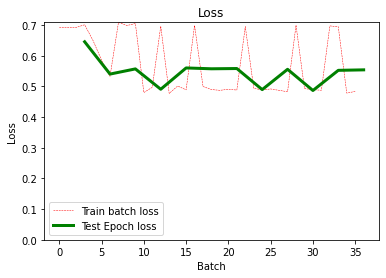

==> Saving model ...
Epoch:  1 | Loss: 0.6925 | Training accuracy: 66.667% | Test accuracy: 66.667% | Epoch Time: 0.03 secs
Epoch:  2 | Loss: 0.6492 | Training accuracy: 100.000% | Test accuracy: 75.000% | Epoch Time: 0.04 secs
Epoch:  3 | Loss: 0.6159 | Training accuracy: 83.333% | Test accuracy: 100.000% | Epoch Time: 0.03 secs
Epoch:  4 | Loss: 0.6137 | Training accuracy: 75.000% | Test accuracy: 66.667% | Epoch Time: 0.03 secs
Epoch:  5 | Loss: 0.6006 | Training accuracy: 100.000% | Test accuracy: 100.000% | Epoch Time: 0.03 secs
Epoch:  6 | Loss: 0.5874 | Training accuracy: 83.333% | Test accuracy: 83.333% | Epoch Time: 0.04 secs
Epoch:  7 | Loss: 0.5787 | Training accuracy: 100.000% | Test accuracy: 83.333% | Epoch Time: 0.04 secs
Epoch:  8 | Loss: 0.5230 | Training accuracy: 75.000% | Test accuracy: 75.000% | Epoch Time: 0.03 secs
Epoch:  9 | Loss: 0.5669 | Training accuracy: 75.000% | Test accuracy: 83.333% | Epoch Time: 0.03 secs
Epoch: 10 | Loss: 0.5679 | Training accuracy: 7

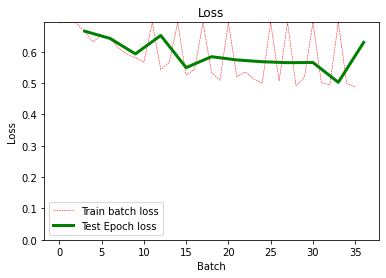

==> Saving model ...


In [25]:
dir = './data'
aug_dir= './aug_data'
preprocess(dir, aug_dir)
process(aug_dir, aug_dir, MLPmodel(18816), "MLP_test")
process(aug_dir, aug_dir, LinearReg(18816), "LR_test")

In [ ]:
class patches_DataSet(torchvision.datasets.DatasetFolder):
  def __init__(root='./data'):
    super(torchvision.datasets.DatasetFolder, seld).init__(root=root, loader=torchvision.io.read_image, extensions='.png')

  def find_classes(dir):
    return None